# **CLARA: Enhancing Multimodal Sentiment Analysis via Efficient Vision-Language Fusion**

## ***MVSA-Multiple Dataset***
---

## 👥 Authors

**Phuong Lam** · lamphuong.ict89@gmail.com · Ho Chi Minh City University of Foreign Languages-Information Technology (HUFLIT), Vietnam

**Tuoi Thi Phan** · pttuoi@ntt.edu.vn · Nguyen Tat Thanh University, Vietnam

**Thien Khai Tran** ✉️ · thientk@huit.edu.vn · Ho Chi Minh City University of Industry and Trade (HUIT), Vietnam

---

## 📝 About

**CLARA** (Co-attention Learning for Robust multimodal sentiment Analysis) is a parameter-efficient framework for multimodal sentiment analysis on social media image-text pairs with multiple images per post.

**Key Highlights:**
- **73.45% F1-Weighted** on MVSA-Multiple (SOTA)
- **3.5% trainable parameters** (9.85M / 281.17M)
- Under review at *The Visual Computer* (Springer)
- GitHub: https://github.com/phuonglamgithub/CLARA
- DOI: https://doi.org/10.5281/zenodo.17862924

**Architecture:** CLIP (vision) + DeBERTa (text) + LoRA adapters + Bidirectional Co-Attention + Verification Module

**Challenge:** MVSA-Multiple has extreme class imbalance (only 3.2% negative samples), requiring specialized handling with 9.44× oversampling.


## **(0) Installing Library**

In [4]:
# ============================== 0) SETUP ==============================
import sys, importlib
def _pip_quiet(pkgs):
    import subprocess
    for p in pkgs:
        try:
            importlib.import_module(p.split("[")[0].split("==")[0])
        except Exception:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", p])

_pip_quiet([
    "transformers==4.42.4",
    "peft==0.11.1",
    "accelerate>=0.33.0",
    "scikit-learn",
    "plotly"
])

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    print("✅ Google Drive mounted")
except Exception:
    print("⚠️  Not in Colab")

import os, random, warnings
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW

from transformers import (
    CLIPProcessor, CLIPVisionModel,
    DebertaV2Tokenizer, DebertaV2Model,
    get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import plotly.graph_objects as go

warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted


## **(1) IMPORTS & CONFIG**

In [ ]:
CONFIG = {
    # Paths
    'text_dir': "/your/path/Dataset/MVSA_Multiple/data",
    'label_file': "/your/path/Dataset/MVSA_Multiple/labelResultAll.txt",

    # Models
    'vision_model_id': "openai/clip-vit-base-patch32",
    'text_model_id': "microsoft/deberta-v3-base",

    # Architecture
    'hidden_dim': 512,
    'num_classes': 3,
    'coattn_layers': 2,
    'coattn_heads': 8,
    'coattn_dropout': 0.1,

    # LoRA
    'enable_clip_lora': True,
    'lora_clip': {'r': 32, 'alpha': 64, 'dropout': 0.05},
    'lora_deb':  {'r': 64, 'alpha': 128, 'dropout': 0.10},

    # Training
    'batch_size': 48,
    'learning_rate': 5e-5,
    'weight_decay': 0.01,
    'max_epochs': 50,
    'early_stopping_patience': 12,
    'warmup_ratio': 0.16,
    'grad_accum_steps': 2,

    # Data
    'require_unanimous': True,     # 3/3 đồng thuận
    'require_cross_agree': True,   # text == image
    'use_soft_labels': False,
    'train_ratio': 0.7,
    'val_ratio': 0.15,

    # System
    'max_length': 128,
    'num_workers': 6,
    'pin_memory': True,
    'persistent_workers': True,
    'prefetch_factor': 2,
    'seed': 42,

    # Loss / Behavior (tối ưu Negative)
    'label_smoothing': 0.02,
    'consistency_weight': 0.10,
    'pred_veri_weight': 0.30,
    'feedback_tau': 0.5,

    'negative_class_boost': 12.0,     # sampler & class-weight boost
    'negative_focal_gamma': 4.0,      # focal gamma for Negative
    'negative_bias_posthoc': 0.6,     # simple post-hoc bias for Negative

    'min_ratio_negative': 0.30,       # enforce min Negative ratio in sampler

    # Mixup for Negative
    'use_mixup_negative': True,
    'mixup_alpha': 0.4,
}

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(CONFIG['seed'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n{'='*70}\nCLARA TRAIN — MVSA-Multiple\n{'='*70}")
print("✅ Device:", device)
if torch.cuda.is_available():
    print("   GPU:", torch.cuda.get_device_name(0))

# TF32 + AMP
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass
AMP_DTYPE = torch.bfloat16 if torch.cuda.is_available() else torch.float32


CLARA TRAIN — MVSA-Multiple
✅ Device: cuda
   GPU: NVIDIA L4


## **(2) DATA LOADING — MVSA-Multiple**

In [6]:

@dataclass
class MVSASample:
    image_path: str
    text_path: str
    image_id: str
    text_ann1: str; text_ann2: str; text_ann3: str
    image_ann1: str; image_ann2: str; image_ann3: str
    text_majority: str
    image_majority: str
    combined_majority: str
    text_unanimous: bool
    image_unanimous: bool

    @property
    def text(self):
        if not hasattr(self, '_text_cache'):
            try:
                with open(self.text_path, 'r', encoding='utf-8', errors='ignore') as f:
                    self._text_cache = f.read().strip()
            except Exception:
                self._text_cache = ""
        return self._text_cache

class MVSALoader:
    def __init__(self, text_dir: str, label_file: str):
        self.text_dir = Path(text_dir)
        self.label_file = Path(label_file)
        self.samples: List[MVSASample] = []

    @staticmethod
    def _check_unanimous(labels: List[str]) -> Tuple[str, bool]:
        return (labels[0], True) if len(set(labels)) == 1 else (labels[0], False)

    def load(self, require_unanimous=True, require_cross_agree=True):
        print("\n📂 LOADING with strict filters:",
              f"Unanimous={require_unanimous}, Cross-agree={require_cross_agree}")
        buf = {}
        with open(self.label_file, 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()
        for line in lines[1:]:
            p = line.strip().split('\t')
            if len(p) < 4:
                continue
            img_id = p[0].strip()
            try:
                t1, i1 = [x.strip().lower() for x in p[1].split(',')]
                t2, i2 = [x.strip().lower() for x in p[2].split(',')]
                t3, i3 = [x.strip().lower() for x in p[3].split(',')]
            except Exception:
                continue
            t_lab, t_uni = self._check_unanimous([t1, t2, t3])
            i_lab, i_uni = self._check_unanimous([i1, i2, i3])
            if require_unanimous and (not t_uni or not i_uni):
                continue
            if require_cross_agree and (t_lab != i_lab):
                continue
            buf[img_id] = dict(
                text_ann1=t1, text_ann2=t2, text_ann3=t3,
                image_ann1=i1, image_ann2=i2, image_ann3=i3,
                text_majority=t_lab, image_majority=i_lab, combined_majority=t_lab,
                text_unanimous=t_uni, image_unanimous=i_uni
            )

        txt_files = {f.stem: f for f in self.text_dir.glob('*.txt')}
        img_exts = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
        self.samples = []
        for img_id, info in buf.items():
            if img_id not in txt_files:
                continue
            ip = None
            for e in img_exts:
                c = self.text_dir / f"{img_id}{e}"
                if c.exists():
                    ip = c
                    break
            if ip is None:
                continue
            self.samples.append(MVSASample(
                image_path=str(ip), text_path=str(txt_files[img_id]),
                image_id=img_id, **info
            ))

        cnt = Counter([s.combined_majority for s in self.samples])
        n = len(self.samples)
        print(f"   ✓ Loaded: {n}")
        if n > 0:
            for lab in ['positive', 'neutral', 'negative']:
                c = cnt.get(lab, 0)
                print(f"   - {lab.capitalize():8s}: {c:4d} ({c/max(1,n)*100:5.1f}%)")
        return self.samples

    def split(self, train_ratio=0.7, val_ratio=0.15, seed=42):
        random.seed(seed)
        groups = {'positive': [], 'neutral': [], 'negative': []}
        for s in self.samples:
            groups[s.combined_majority].append(s)
        train, val, test = [], [], []
        for arr in groups.values():
            random.shuffle(arr)
            n = len(arr)
            n_tr = int(n * train_ratio)
            n_va = int(n * val_ratio)
            train.extend(arr[:n_tr])
            val.extend(arr[n_tr:n_tr+n_va])
            test.extend(arr[n_tr+n_va:])
        random.shuffle(train); random.shuffle(val); random.shuffle(test)
        return train, val, test

loader = MVSALoader(CONFIG['text_dir'], CONFIG['label_file'])
all_samples = loader.load(CONFIG['require_unanimous'], CONFIG['require_cross_agree'])
if len(all_samples) == 0:
    raise ValueError("❌ Empty dataset. Relax filters.")

train_samples, val_samples, test_samples = loader.split(
    CONFIG['train_ratio'], CONFIG['val_ratio'], CONFIG['seed']
)

print("\n" + "="*70 + "\nSPLIT\n" + "="*70)
for name, arr in [("Train", train_samples), ("Val", val_samples), ("Test", test_samples)]:
    c = Counter([s.combined_majority for s in arr])
    print(
        f"   {name:5s}: {len(arr):4d} | "
        f"Pos:{c.get('positive',0):4d} Neu:{c.get('neutral',0):4d} Neg:{c.get('negative',0):4d}"
    )


📂 LOADING with strict filters: Unanimous=True, Cross-agree=True
   ✓ Loaded: 3555
   - Positive: 2173 ( 61.1%)
   - Neutral : 1268 ( 35.7%)
   - Negative:  114 (  3.2%)

SPLIT
   Train: 2487 | Pos:1521 Neu: 887 Neg:  79
   Val  :  532 | Pos: 325 Neu: 190 Neg:  17
   Test :  536 | Pos: 327 Neu: 191 Neg:  18


## **(3) DATASET & DATALOADER**

In [7]:
clip_processor = CLIPProcessor.from_pretrained(CONFIG['vision_model_id'])
tokenizer      = DebertaV2Tokenizer.from_pretrained(CONFIG['text_model_id'])
print("\n✅ Processors ready")

class MVSADataset(Dataset):
    def __init__(self, samples, use_mixup=False, mixup_alpha=0.4):
        self.samples = samples
        self.use_mixup = use_mixup
        self.mixup_alpha = mixup_alpha
        self.map = {'positive': 0, 'neutral': 1, 'negative': 2}
        self.neg_idx = [i for i, s in enumerate(samples) if s.combined_majority == 'negative']

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        try:
            img = Image.open(s.image_path).convert('RGB')
        except Exception:
            img = Image.new('RGB', (224, 224), (0, 0, 0))
        text = s.text
        label = self.map[s.combined_majority]
        # Mixup for Negative
        if self.use_mixup and s.combined_majority == 'negative' and len(self.neg_idx) > 1 and random.random() < 0.5:
            other_idx = random.choice([i for i in self.neg_idx if i != idx])
            try:
                img2 = Image.open(self.samples[other_idx].image_path).convert('RGB')
                lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
                arr = (np.array(img) * lam + np.array(img2) * (1-lam)).astype(np.uint8)
                img = Image.fromarray(arr)
            except Exception:
                pass
        return {'image': img, 'text': text, 'label': label}

def collate_fn(batch):
    images = [b['image'] for b in batch]
    pv = clip_processor(images=images, return_tensors='pt')['pixel_values']
    texts = [b['text'] for b in batch]
    enc = tokenizer(
        texts, max_length=CONFIG['max_length'],
        padding=True, truncation=True, return_tensors='pt'
    )
    labels = torch.tensor([b['label'] for b in batch], dtype=torch.long)
    return {
        'pixel_values': pv,
        'input_ids': enc['input_ids'],
        'attention_mask': enc['attention_mask'],
        'labels': labels
    }

def build_extreme_negative_sampler(samples, neg_boost=12.0, min_ratio_neg=0.30):
    if len(samples) == 0:
        return None, True
    labs = [s.combined_majority for s in samples]
    cnt = Counter(labs)
    if not cnt:
        return None, True
    total = sum(cnt.values())
    k = len(cnt)
    weights = {}
    for lab, c in cnt.items():
        base = total / (k * c)
        weights[lab] = base * (neg_boost if lab == 'negative' else 1.0)
    # Enforce min Negative ratio
    cur_ratio = cnt.get('negative', 0) / max(1, total)
    if cur_ratio < min_ratio_neg and cnt.get('negative', 0) > 0:
        scale = min_ratio_neg / max(1e-8, cur_ratio)
        weights['negative'] *= scale
        print(f"Negative min-ratio boost x{scale:.2f} → target {min_ratio_neg*100:.1f}%")
    sw = torch.tensor(
        [float(weights.get(s.combined_majority, 1.0)) for s in samples],
        dtype=torch.double
    )
    if sw.numel() == 0 or not torch.isfinite(sw).all():
        return None, True
    return WeightedRandomSampler(sw, num_samples=sw.numel(), replacement=True), False

train_ds = MVSADataset(
    train_samples,
    use_mixup=CONFIG['use_mixup_negative'],
    mixup_alpha=CONFIG['mixup_alpha']
)
val_ds   = MVSADataset(val_samples,  use_mixup=False)
test_ds  = MVSADataset(test_samples, use_mixup=False)

sampler, use_shuffle = build_extreme_negative_sampler(
    train_samples,
    CONFIG['negative_class_boost'],
    CONFIG['min_ratio_negative']
)

train_loader = DataLoader(
    train_ds, batch_size=CONFIG['batch_size'],
    sampler=None if use_shuffle else sampler,
    shuffle=use_shuffle,
    num_workers=CONFIG['num_workers'],
    pin_memory=CONFIG['pin_memory'],
    persistent_workers=CONFIG['persistent_workers'],
    prefetch_factor=CONFIG['prefetch_factor'],
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_ds, batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=CONFIG['pin_memory'],
    persistent_workers=CONFIG['persistent_workers'],
    prefetch_factor=CONFIG['prefetch_factor'],
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_ds, batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=CONFIG['pin_memory'],
    persistent_workers=CONFIG['persistent_workers'],
    prefetch_factor=CONFIG['prefetch_factor'],
    collate_fn=collate_fn
)

print(f"\n✅ DataLoaders: Train={len(train_loader)} | Val={len(val_loader)} | Test={len(test_loader)}")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]


✅ Processors ready
Negative min-ratio boost x9.44 → target 30.0%

✅ DataLoaders: Train=52 | Val=12 | Test=12


## **(4) MODEL CLARA & ADAPTER**

In [8]:
class CoAttentionFusion(nn.Module):
    def __init__(self, vision_dim=768, text_dim=768, hidden_dim=512,
                 num_layers=2, num_heads=8, dropout=0.1):
        super().__init__()
        self.v_proj = nn.Linear(vision_dim, hidden_dim)
        self.t_proj = nn.Linear(text_dim, hidden_dim)
        self.cross = nn.ModuleList([
            nn.MultiheadAttention(
                hidden_dim, num_heads, dropout=dropout, batch_first=True
            )
            for _ in range(num_layers)
        ])
        self.norms = nn.ModuleList([
            nn.LayerNorm(hidden_dim) for _ in range(num_layers * 2)
        ])
        self.fuse = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

    def forward(self, v_feat, t_feat):
        v = self.v_proj(v_feat).unsqueeze(1)
        t = self.t_proj(t_feat).unsqueeze(1)
        for i, attn in enumerate(self.cross):
            t_attn, _ = attn(t, v, v)
            t = self.norms[i*2](t + t_attn)
            v_attn, _ = attn(v, t, t)
            v = self.norms[i*2+1](v + v_attn)
        fused = torch.cat([v.squeeze(1), t.squeeze(1)], dim=-1)
        return self.fuse(fused)

class CLARAModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.h = config['hidden_dim']
        self.C = config['num_classes']
        self.tau = config['feedback_tau']

        # Vision + LoRA → VisionOnly wrapper
        _vision = CLIPVisionModel.from_pretrained(config['vision_model_id'])
        if config['enable_clip_lora']:
            lcfg = LoraConfig(
                r=config['lora_clip']['r'],
                lora_alpha=config['lora_clip']['alpha'],
                lora_dropout=config['lora_clip']['dropout'],
                target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],
                task_type=TaskType.FEATURE_EXTRACTION
            )
            _vision = get_peft_model(_vision, lcfg)
        base = _vision
        # Unwrap if there are wrapper modules
        for _ in range(5):
            progressed = False
            for attr in ("get_base_model", "base_model", "model", "module"):
                if hasattr(base, attr):
                    obj = getattr(base, attr)
                    try:
                        base = obj() if callable(obj) else obj
                        progressed = True
                        break
                    except Exception:
                        pass
            if not progressed:
                break

        class VisionOnly(nn.Module):
            def __init__(self, b):
                super().__init__(); self.b = b
            def forward(self, *, pixel_values):
                return self.b.forward(pixel_values=pixel_values)

        self.vision = VisionOnly(base)
        self.vision_core = base  # for freeze/unfreeze

        # Text + LoRA
        deb = DebertaV2Model.from_pretrained(config['text_model_id'])
        lcfgd = LoraConfig(
            r=config['lora_deb']['r'],
            lora_alpha=config['lora_deb']['alpha'],
            lora_dropout=config['lora_deb']['dropout'],
            target_modules=["query_proj", "key_proj", "value_proj"],
            task_type=TaskType.FEATURE_EXTRACTION
        )
        self.text = get_peft_model(deb, lcfgd)

        v_dim = getattr(self.vision_core.config, 'hidden_size', 768)
        t_dim = self.text.config.hidden_size
        self.fusion = CoAttentionFusion(
            v_dim, t_dim, config['hidden_dim'],
            config['coattn_layers'], config['coattn_heads'],
            config['coattn_dropout']
        )

        self.pred = nn.Sequential(
            nn.Linear(self.h, self.h//2),
            nn.LayerNorm(self.h//2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(self.h//2, self.C)
        )
        self.veri = nn.Sequential(
            nn.Linear(self.h, self.h//2),
            nn.LayerNorm(self.h//2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(self.h//2, self.C)
        )
        self.feed = nn.Sequential(
            nn.Linear(self.h + self.C, self.h),
            nn.LayerNorm(self.h),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        self.final = nn.Linear(self.h, self.C)

    # keyword-only to avoid CLIP arg mismatch
    def forward(self, *, pixel_values, input_ids, attention_mask):
        v_out = self.vision(pixel_values=pixel_values)
        v_feat = v_out.last_hidden_state.mean(dim=1)

        t_out = self.text(input_ids=input_ids, attention_mask=attention_mask)
        t_seq = t_out.last_hidden_state
        mask = attention_mask.unsqueeze(-1).float()
        t_feat = (t_seq * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)

        fused = self.fusion(v_feat, t_feat)
        lg_p = self.pred(fused)
        lg_v = self.veri(fused)

        p_v = F.softmax(lg_v / self.tau, dim=-1).detach()
        p_p = F.softmax(lg_p / self.tau, dim=-1).detach()

        ref = self.feed(torch.cat([fused, (p_v - p_p)], dim=-1))
        lg_f = self.final(ref)
        return lg_f, lg_p, lg_v

print("\n Initializing CLARA…")
model = CLARAModel(CONFIG).to(device)
tot = sum(p.numel() for p in model.parameters())
trn = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" Params: {trn:,}/{tot:,} ({trn/tot*100:.2f}%)")


 Initializing CLARA…


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

 Params: 9,848,841/281,136,393 (3.50%)


## **(5) LOSS & OPTIMIZER**

In [9]:

train_labels = [s.combined_majority for s in train_samples]
cc = Counter(train_labels)
ce_w = torch.tensor([
    float(cc.get('positive', 1)),
    float(cc.get('neutral', 1)),
    float(cc.get('negative', 1)) * CONFIG['negative_class_boost']
], dtype=torch.float, device=device)
ce_w = (ce_w.sum() / (3.0 * ce_w)).clamp_min(1e-8)
print("\n Class Weights (boosted Negative):",
      f"Pos={float(ce_w[0]):.3f} Neu={float(ce_w[1]):.3f} Neg={float(ce_w[2]):.3f}")

class ExtremeFocalLoss(nn.Module):
    def __init__(self, gamma_map={0:1.0, 1:2.0, 2:4.0}, weight=None, eps=0.02):
        super().__init__()
        self.gamma_map = gamma_map
        self.weight = weight
        self.eps = eps

    def forward(self, logits, target):
        n = logits.size(-1)
        logp = F.log_softmax(logits, dim=-1)
        with torch.no_grad():
            smooth = torch.full_like(logp, self.eps/(n-1))
            smooth.scatter_(1, target.unsqueeze(1), 1.0 - self.eps)
        p = F.softmax(logits, dim=-1).clamp_min(1e-8)
        pt = p.gather(1, target.unsqueeze(1)).squeeze(1)
        gamma = torch.tensor(
            [self.gamma_map.get(int(t.item()), 1.0) for t in target],
            device=logits.device, dtype=logits.dtype
        )
        focal = (1-pt)**gamma
        loss = -(smooth * logp).sum(dim=1)
        loss = focal * loss
        if self.weight is not None:
            w = self.weight[target]
            loss = loss * w
        return loss.mean()

criterion = ExtremeFocalLoss(
    gamma_map={0:1.0, 1:2.0, 2:CONFIG['negative_focal_gamma']},
    weight=ce_w,
    eps=CONFIG['label_smoothing']
)

optimizer = AdamW(model.parameters(),
                  lr=CONFIG['learning_rate'],
                  weight_decay=CONFIG['weight_decay'])
total_steps = max(1, (len(train_loader)*CONFIG['max_epochs']) // max(1, CONFIG['grad_accum_steps']))
warmup_steps = int(total_steps * CONFIG['warmup_ratio'])
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

def set_trainable_except_lora(module, flag: bool):
    for n, p in module.named_parameters():
        if 'lora_' in n:
            p.requires_grad = True
        else:
            p.requires_grad = flag

# Freeze encoders (only LoRA trainable)
set_trainable_except_lora(model.text, False)
set_trainable_except_lora(model.vision_core, False)
print("🔒 Encoders frozen (LoRA trainable only)")


 Class Weights (boosted Negative): Pos=0.735 Neu=1.261 Neg=1.180
🔒 Encoders frozen (LoRA trainable only)


## **(6) TRAIN / EVAL FUNCTIONS**

In [ ]:
# ============================== TRAINER FOR MVSA-Multiple ==============================
class Trainer:
    """
    Trainer for CLARA on MVSA-Multiple.

    - Loss: loss_f + pred_veri_weight*(loss_p + loss_v) + consistency_weight*cons
    - Early stopping: Validation F1-Weighted (F1-W)
    - Logs `history` for learning curves (train_loss, val_acc, val_f1_w, val_f1_m)
    """

    def __init__(self, model, train_loader, val_loader,
                 config, device, criterion, amp_dtype,
                 save_path="best_clara_mvsa_multi.pt"):
        self.model   = model
        self.tl      = train_loader
        self.vl      = val_loader
        self.cfg     = config
        self.device  = device
        self.crit    = criterion
        self.amp_dtype = amp_dtype
        self.save_path = save_path

        # Optimizer + Scheduler
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=self.cfg["learning_rate"],
            weight_decay=self.cfg["weight_decay"]
        )
        # chia cho grad_accum_steps để ra số step optimizer thực tế
        total_steps = max(
            1,
            (len(self.tl) * self.cfg["max_epochs"]) // max(1, self.cfg["grad_accum_steps"])
        )
        warmup_steps = int(total_steps * self.cfg["warmup_ratio"])
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer, warmup_steps, total_steps
        )

        # Early stopping (F1-Weighted làm metric chính)
        self.best_f1w = 0.0
        self.pat = 0
        self.patience = self.cfg["early_stopping_patience"]

        # History để vẽ learning curve
        # (đặt F1-W lên trước cho rõ là metric chính)
        self.history = []   # {"epoch","train_loss","val_acc","val_f1_w","val_f1_m"}

    # ---------------- 1) Each epoch train ----------------
    def train_epoch(self, epoch: int) -> float:
        self.model.train()
        total = 0.0
        accum = max(1, self.cfg["grad_accum_steps"])

        self.optimizer.zero_grad(set_to_none=True)
        pbar = tqdm(self.tl, desc=f"Epoch {epoch}", leave=False)

        for step, b in enumerate(pbar, start=1):
            pv  = b["pixel_values"].to(self.device, non_blocking=True)
            ids = b["input_ids"].to(self.device, non_blocking=True)
            att = b["attention_mask"].to(self.device, non_blocking=True)
            lab = b["labels"].long().to(self.device, non_blocking=True)

            with torch.cuda.amp.autocast(dtype=self.amp_dtype):
                # model trả về 3 head: final, prediction, verification
                lg_f, lg_p, lg_v = self.model(
                    pixel_values=pv,
                    input_ids=ids,
                    attention_mask=att
                )
                loss_f = self.crit(lg_f, lab)
                loss_p = self.crit(lg_p, lab)
                loss_v = self.crit(lg_v, lab)

                # Consistency between Prediction & Verification
                pp  = F.softmax(lg_p, dim=-1)
                pv_ = F.softmax(lg_v, dim=-1)
                kl1 = F.kl_div((pp  + 1e-8).log(), pv_, reduction="batchmean")
                kl2 = F.kl_div((pv_ + 1e-8).log(), pp,  reduction="batchmean")
                cons = kl1 + kl2

                loss = (
                    loss_f
                    + self.cfg["pred_veri_weight"] * (loss_p + loss_v)
                    + self.cfg["consistency_weight"] * cons
                )
                loss = loss / accum

            loss.backward()

            if step % accum == 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                self.scheduler.step()
                self.optimizer.zero_grad(set_to_none=True)

            total += float(loss.detach().cpu())
            pbar.set_postfix({"loss": f"{loss.item() * accum:.4f}"})

        return total / max(1, len(self.tl))

    # ---------------- 2) Evaluate ----------------
    @torch.no_grad()
    def evaluate(self, loader):
        self.model.eval()
        P, Y = [], []

        for b in tqdm(loader, desc="Evaluating", leave=False):
            pv  = b["pixel_values"].to(self.device, non_blocking=True)
            ids = b["input_ids"].to(self.device, non_blocking=True)
            att = b["attention_mask"].to(self.device, non_blocking=True)
            lab = b["labels"].long().to(self.device, non_blocking=True)

            with torch.cuda.amp.autocast(dtype=self.amp_dtype):
                lg_f, _, _ = self.model(
                    pixel_values=pv,
                    input_ids=ids,
                    attention_mask=att
                )
                preds = lg_f.argmax(dim=-1)

            P.extend(preds.cpu().tolist())
            Y.extend(lab.cpu().tolist())

        acc  = accuracy_score(Y, P)
        f1_m = f1_score(Y, P, average="macro")
        f1_w = f1_score(Y, P, average="weighted")
        return acc, f1_m, f1_w, P, Y

    # ---------------- 3) Train loop ----------------
    def train(self):
        print("\n" + "="*70 + "\nTRAINING\n" + "="*70)

        for epoch in range(1, self.cfg["max_epochs"] + 1):
            # Unfreeze encoders sau 2 epoch (giống code gốc)
            if epoch == 3:
                set_trainable_except_lora(self.model.text, True)
                set_trainable_except_lora(self.model.vision_core, True)
                print("Encoders unfrozen")

            tr_loss = self.train_epoch(epoch)
            va_acc, va_f1m, va_f1w, _, _ = self.evaluate(self.vl)

            # Log history cho learning curve (ưu tiên F1-W)
            self.history.append({
                "epoch":      epoch,
                "train_loss": float(tr_loss),
                "val_acc":    float(va_acc),
                "val_f1_w":   float(va_f1w),
                "val_f1_m":   float(va_f1m),
            })

            print(f"\n Epoch {epoch}/{self.cfg['max_epochs']}")
            print(
                f"   Loss: {tr_loss:.4f} | "
                f"Acc: {va_acc:.4f} | "
                f"F1-Weighted: {va_f1w:.4f} | "
                f"F1-Macro: {va_f1m:.4f}"
            )

            # Early stopping theo F1-Weighted
            if va_f1w > self.best_f1w:
                self.best_f1w = va_f1w
                self.pat = 0
                torch.save(self.model.state_dict(), self.save_path)
                print(f"   ✅ New best! (F1-Weighted={self.best_f1w:.4f})")
            else:
                self.pat += 1
                if self.pat >= self.patience:
                    print("🛑 Early stopping")
                    break

        # Reload best checkpoint
        try:
            state = torch.load(self.save_path, map_location=self.device)
            self.model.load_state_dict(state)
            print(f"\n✅ Loaded best checkpoint from {self.save_path}")
        except Exception as e:
            print(f"\n⚠️ Could not load best checkpoint: {e}")

        # Returns the best F1-Weighted (primary metric)
        return self.best_f1w


## **(7) TRAIN LOOP**

In [11]:
trainer_multi = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=CONFIG,
    device=device,
    criterion=criterion,
    amp_dtype=AMP_DTYPE,
    save_path="clara_mvsa_multi.pt",
)

best_f1_macro = trainer_multi.train()
history = trainer_multi.history



TRAINING


Epoch 1:   0%|          | 0/52 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]


 Epoch 1/50
   Loss: 0.2441 | Acc: 0.0320 | F1-Weighted: 0.0020 | F1-Macro: 0.0206
   ✅ New best! (F1-Weighted=0.0020)



 Epoch 2/50
   Loss: 0.0336 | Acc: 0.0320 | F1-Weighted: 0.0020 | F1-Macro: 0.0206
Encoders unfrozen



 Epoch 3/50
   Loss: 0.0217 | Acc: 0.0320 | F1-Weighted: 0.0020 | F1-Macro: 0.0206



 Epoch 4/50
   Loss: 0.0174 | Acc: 0.3759 | F1-Weighted: 0.3698 | F1-Macro: 0.3285
   ✅ New best! (F1-Weighted=0.3698)



 Epoch 5/50
   Loss: 0.0082 | Acc: 0.3139 | F1-Weighted: 0.1883 | F1-Macro: 0.2590



 Epoch 6/50
   Loss: 0.0090 | Acc: 0.5320 | F1-Weighted: 0.5434 | F1-Macro: 0.4842
   ✅ New best! (F1-Weighted=0.5434)



 Epoch 7/50
   Loss: 0.0085 | Acc: 0.4812 | F1-Weighted: 0.4737 | F1-Macro: 0.3271



 Epoch 8/50
   Loss: 0.0130 | Acc: 0.5921 | F1-Weighted: 0.5206 | F1-Macro: 0.3819



 Epoch 9/50
   Loss: 0.0096 | Acc: 0.2274 | F1-Weighted: 0.1443 | F1-Macro: 0.1812



 Epoch 10/50
   Loss: 0.0168 | Acc: 0.4380 | F1-Weighted: 0.4771 | F1-Macro: 0.3348



 Epoch 11/50
   Loss: 0.0111 | Acc: 0.6241 | F1-Weighted: 0.5075 | F1-Macro: 0.3855



 Epoch 12/50
   Loss: 0.0075 | Acc: 0.3327 | F1-Weighted: 0.1861 | F1-Macro: 0.2821



 Epoch 13/50
   Loss: 0.0059 | Acc: 0.6184 | F1-Weighted: 0.5399 | F1-Macro: 0.4289



 Epoch 14/50
   Loss: 0.0043 | Acc: 0.6410 | F1-Weighted: 0.5776 | F1-Macro: 0.4834
   ✅ New best! (F1-Weighted=0.5776)



 Epoch 15/50
   Loss: 0.0046 | Acc: 0.4925 | F1-Weighted: 0.5016 | F1-Macro: 0.4352



 Epoch 16/50
   Loss: 0.0080 | Acc: 0.4398 | F1-Weighted: 0.3857 | F1-Macro: 0.4022



 Epoch 17/50
   Loss: 0.0065 | Acc: 0.7199 | F1-Weighted: 0.7025 | F1-Macro: 0.5698
   ✅ New best! (F1-Weighted=0.7025)



 Epoch 18/50
   Loss: 0.0053 | Acc: 0.6165 | F1-Weighted: 0.6276 | F1-Macro: 0.5350



 Epoch 19/50
   Loss: 0.0044 | Acc: 0.7237 | F1-Weighted: 0.6923 | F1-Macro: 0.5498



 Epoch 20/50
   Loss: 0.0035 | Acc: 0.6748 | F1-Weighted: 0.6957 | F1-Macro: 0.5548



 Epoch 21/50
   Loss: 0.0047 | Acc: 0.7162 | F1-Weighted: 0.7164 | F1-Macro: 0.5770
   ✅ New best! (F1-Weighted=0.7164)



 Epoch 22/50
   Loss: 0.0046 | Acc: 0.5996 | F1-Weighted: 0.6089 | F1-Macro: 0.5156



 Epoch 23/50
   Loss: 0.0034 | Acc: 0.7180 | F1-Weighted: 0.7230 | F1-Macro: 0.5984
   ✅ New best! (F1-Weighted=0.7230)



 Epoch 24/50
   Loss: 0.0045 | Acc: 0.7068 | F1-Weighted: 0.6838 | F1-Macro: 0.5571



 Epoch 25/50
   Loss: 0.0049 | Acc: 0.7406 | F1-Weighted: 0.7390 | F1-Macro: 0.6007
   ✅ New best! (F1-Weighted=0.7390)



 Epoch 26/50
   Loss: 0.0035 | Acc: 0.4831 | F1-Weighted: 0.4372 | F1-Macro: 0.4010



 Epoch 27/50
   Loss: 0.0052 | Acc: 0.7425 | F1-Weighted: 0.7425 | F1-Macro: 0.5920
   ✅ New best! (F1-Weighted=0.7425)



 Epoch 28/50
   Loss: 0.0032 | Acc: 0.7406 | F1-Weighted: 0.7284 | F1-Macro: 0.5853



 Epoch 29/50
   Loss: 0.0037 | Acc: 0.7162 | F1-Weighted: 0.7235 | F1-Macro: 0.5866



 Epoch 30/50
   Loss: 0.0074 | Acc: 0.7293 | F1-Weighted: 0.7156 | F1-Macro: 0.5773



 Epoch 31/50
   Loss: 0.0059 | Acc: 0.7237 | F1-Weighted: 0.7202 | F1-Macro: 0.5759



 Epoch 32/50
   Loss: 0.0035 | Acc: 0.6259 | F1-Weighted: 0.6370 | F1-Macro: 0.5318



 Epoch 33/50
   Loss: 0.0028 | Acc: 0.7274 | F1-Weighted: 0.7326 | F1-Macro: 0.6074



 Epoch 34/50
   Loss: 0.0042 | Acc: 0.7538 | F1-Weighted: 0.7526 | F1-Macro: 0.6207
   ✅ New best! (F1-Weighted=0.7526)



 Epoch 35/50
   Loss: 0.0031 | Acc: 0.6673 | F1-Weighted: 0.6735 | F1-Macro: 0.5717



 Epoch 36/50
   Loss: 0.0027 | Acc: 0.7425 | F1-Weighted: 0.7439 | F1-Macro: 0.6003



 Epoch 37/50
   Loss: 0.0047 | Acc: 0.7368 | F1-Weighted: 0.7240 | F1-Macro: 0.5510



 Epoch 38/50
   Loss: 0.0031 | Acc: 0.7124 | F1-Weighted: 0.7186 | F1-Macro: 0.5793



 Epoch 39/50
   Loss: 0.0029 | Acc: 0.6880 | F1-Weighted: 0.6950 | F1-Macro: 0.5644



 Epoch 40/50
   Loss: 0.0023 | Acc: 0.7162 | F1-Weighted: 0.7203 | F1-Macro: 0.5782



 Epoch 41/50
   Loss: 0.0033 | Acc: 0.7049 | F1-Weighted: 0.7109 | F1-Macro: 0.5732



 Epoch 42/50
   Loss: 0.0031 | Acc: 0.7500 | F1-Weighted: 0.7403 | F1-Macro: 0.5918



 Epoch 43/50
   Loss: 0.0031 | Acc: 0.7293 | F1-Weighted: 0.7307 | F1-Macro: 0.5870



 Epoch 44/50
   Loss: 0.0039 | Acc: 0.6447 | F1-Weighted: 0.6485 | F1-Macro: 0.5259



 Epoch 45/50
   Loss: 0.0026 | Acc: 0.7124 | F1-Weighted: 0.7169 | F1-Macro: 0.5658



 Epoch 46/50
   Loss: 0.0032 | Acc: 0.7068 | F1-Weighted: 0.7118 | F1-Macro: 0.5628
🛑 Early stopping

✅ Loaded best checkpoint from clara_mvsa_multi.pt


## **(8) FINAL EVAL + SIMPLE NEGATIVE BIAS**

In [12]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd

def print_cls_report_pandas(y_true, y_pred, labels, title="Classification Report"):
    report_dict = classification_report(
        y_true, y_pred,
        target_names=labels,
        output_dict=True
    )
    df = pd.DataFrame(report_dict).T
    df = df[["precision", "recall", "f1-score", "support"]]  # sắp cột cho đẹp

    print(f"\n📊 {title}:")
    try:
        # Trong Colab/Jupyter sẽ hiển thị bảng đẹp
        from IPython.display import display
        display(df.round(3))
    except Exception:
        # Nếu chỉ có console thì in dạng text
        print(df.round(3).to_string())

# EVALUATE (RAW LOGITS)
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    P, Y = [], []
    for b in loader:
        pv  = b['pixel_values'].to(device, non_blocking=True)
        ids = b['input_ids'].to(device, non_blocking=True)
        att = b['attention_mask'].to(device, non_blocking=True)
        lab = b['labels'].long().to(device, non_blocking=True)

        # model trả về: logits, ..., ...
        lg_f, _, _ = model(
            pixel_values=pv,
            input_ids=ids,
            attention_mask=att
        )
        preds = lg_f.argmax(dim=-1)

        P.extend(preds.cpu().tolist())
        Y.extend(lab.cpu().tolist())

    acc  = accuracy_score(Y, P)
    f1_m = f1_score(Y, P, average='macro')
    f1_w = f1_score(Y, P, average='weighted')
    return acc, f1_m, f1_w, P, Y

# EVALUATE POST-HOC BIAS
@torch.no_grad()
def evaluate_posthoc_bias(model, loader, device, neg_bias=0.6):
    model.eval()
    P, Y = [], []
    # bias: [bias_Pos, bias_Neu, bias_Neg]
    bias = torch.tensor([0.0, 0.0, float(neg_bias)], device=device)

    for b in loader:
        pv  = b['pixel_values'].to(device, non_blocking=True)
        ids = b['input_ids'].to(device, non_blocking=True)
        att = b['attention_mask'].to(device, non_blocking=True)
        lab = b['labels'].long().to(device, non_blocking=True)

        lg_f, _, _ = model(
            pixel_values=pv,
            input_ids=ids,
            attention_mask=att
        )
        preds = (lg_f + bias.view(1, -1)).argmax(dim=-1)

        P.extend(preds.cpu().tolist())
        Y.extend(lab.cpu().tolist())

    acc  = accuracy_score(Y, P)
    f1_m = f1_score(Y, P, average='macro')
    f1_w = f1_score(Y, P, average='weighted')
    return acc, f1_m, f1_w, P, Y

# FINAL EVALUATION
LABELS = ['Positive', 'Neutral', 'Negative']
print("\n" + "="*70 + "\nFINAL EVALUATION (RAW + SIMPLE NEG BIAS)\n" + "="*70)

# Load best checkpoint nếu có
if os.path.exists("best_clara.pt"):
    model.load_state_dict(torch.load("best_clara_multi.pt", map_location=device))

# ----- RAW RESULTS -----
te_acc, te_f1m, te_f1w, te_P, te_Y = evaluate(model, test_loader, device)
print(f"\n🎯 RAW TEST RESULTS:")
print(f"   Accuracy   : {te_acc:.4f}")
print(f"   F1-Macro   : {te_f1m:.4f}")
print(f"   F1-Weighted: {te_f1w:.4f}")

print_cls_report_pandas(
    te_Y, te_P,
    labels=LABELS,
    title="Raw Classification Report"
)

# ----- POST-HOC NEGATIVE BIAS -----
ph_acc, ph_f1m, ph_f1w, ph_P, ph_Y = evaluate_posthoc_bias(
    model, test_loader, device,
    neg_bias=CONFIG['negative_bias_posthoc']
)

print(f"\n🎯 POST-HOC TEST RESULTS (simple Neg bias={CONFIG['negative_bias_posthoc']}):")
print(f"   Accuracy   : {ph_acc:.4f}")
print(f"   F1-Macro   : {ph_f1m:.4f}")
print(f"   F1-Weighted: {ph_f1w:.4f}")

print_cls_report_pandas(
    ph_Y, ph_P,
    labels=LABELS,
    title=f"Post-hoc Classification Report (Neg bias={CONFIG['negative_bias_posthoc']})"
)



FINAL EVALUATION (RAW + SIMPLE NEG BIAS)

🎯 RAW TEST RESULTS:
   Accuracy   : 0.7351
   F1-Macro   : 0.6607
   F1-Weighted: 0.7345

📊 Raw Classification Report:


,precision,recall,f1-score,support
Positive,0.802,0.807,0.805,327.000
Neutral,0.630,0.634,0.632,191.000
Negative,0.600,0.500,0.545,18.000
accuracy,0.735,0.735,0.735,0.735
macro avg,0.678,0.647,0.661,536.000
weighted avg,0.734,0.735,0.735,536.000



🎯 POST-HOC TEST RESULTS (simple Neg bias=0.6):
   Accuracy   : 0.7313
   F1-Macro   : 0.6479
   F1-Weighted: 0.7309

📊 Post-hoc Classification Report (Neg bias=0.6):


,precision,recall,f1-score,support
Positive,0.802,0.807,0.805,327.000
Neutral,0.626,0.623,0.625,191.000
Negative,0.529,0.500,0.514,18.000
accuracy,0.731,0.731,0.731,0.731
macro avg,0.653,0.643,0.648,536.000
weighted avg,0.731,0.731,0.731,536.000


In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go

def plot_confusion_matrix(
    y_true,
    y_pred,
    labels=None,
    title="Confusion Matrix (Row-normalized)"
):

    if labels is None:
        labels = [str(i) for i in sorted(np.unique(y_true))]

    # Raw confusion matrix (counts)
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

    # Row-normalized percentages (per true class)
    row_sums = cm.sum(axis=1, keepdims=True).astype(np.float64)

    # Avoid division by zero if a class has no samples
    with np.errstate(divide="ignore", invalid="ignore"):
        cm_row_perc = np.divide(cm, row_sums, where=row_sums != 0) * 100.0
        cm_row_perc = np.nan_to_num(cm_row_perc)  # convert NaN to 0

    # Text per cell: "count<br>xx.x%"
    text = np.empty_like(cm).astype(object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text[i, j] = f"{cm[i, j]}<br>{cm_row_perc[i, j]:.1f}%"

    fig = go.Figure(
        data=go.Heatmap(
            z=cm_row_perc,              # use row-normalized % for colors
            x=labels,
            y=labels,
            text=text,                  # count + %
            texttemplate="%{text}",
            colorscale="Blues",
            colorbar=dict(title="% per true class"),
            customdata=cm,              # keep raw counts for hover
            hovertemplate=(
                "True: %{y}<br>"
                "Pred: %{x}<br>"
                "Count = %{customdata}<br>"
                "Row Percent = %{z:.1f}%<extra></extra>"
            ),
        )
    )

    fig.update_layout(
        title=title,
        xaxis_title="Predicted label",
        yaxis_title="True label",
        yaxis_autorange="reversed",
        template="plotly_white",
        width=600,
        height=500,
    )

    fig.show()
    return cm, cm_row_perc


# ===== RAW CONFUSION MATRIX (ROW-NORMALIZED) =====
cm_raw, cm_raw_rowperc = plot_confusion_matrix(
    te_Y, te_P,
    labels=["Positive", "Neutral", "Negative"],
    title="CLARA_MVSA-Multiple – Raw Confusion Matrix (Row-normalized, TEST)"
)

# ===== POST-HOC CONFUSION MATRIX (ROW-NORMALIZED) =====
cm_posthoc, cm_posthoc_rowperc = plot_confusion_matrix(
    ph_Y, ph_P,
    labels=["Positive", "Neutral", "Negative"],
    title="CLARA_MVSA-Multiple – Post-hoc Confusion Matrix (Row-normalized, TEST)"
)


In [14]:
# ============================== LEARNING CURVES ==============================
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Convert history (list of dicts) to DataFrame
df_hist = pd.DataFrame(history).sort_values("epoch")

print(df_hist.head())

fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=(
        "Train Loss per Epoch",
        "Validation Accuracy per Epoch",
        "Validation F1-Weighted per Epoch",
        "Validation F1-Macro per Epoch"
    ),
    shared_xaxes=False
)

# --------- 1) Train Loss (row=1, col=1) ----------
fig.add_trace(
    go.Scatter(
        x=df_hist["epoch"],
        y=df_hist["train_loss"],
        mode="lines+markers",
        name="Train Loss"
    ),
    row=1, col=1
)

fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_yaxes(title_text="Train Loss", row=1, col=1)

# --------- 2) Val Accuracy (row=1, col=2) ----------
fig.add_trace(
    go.Scatter(
        x=df_hist["epoch"],
        y=df_hist["val_acc"],
        mode="lines+markers",
        name="Val Accuracy"
    ),
    row=1, col=2
)

fig.update_xaxes(title_text="Epoch", row=1, col=2)
fig.update_yaxes(title_text="Val Accuracy", row=1, col=2)

# --------- 3) Val F1-Weighted (row=2, col=1) ----------
fig.add_trace(
    go.Scatter(
        x=df_hist["epoch"],
        y=df_hist["val_f1_w"],
        mode="lines+markers",
        name="Val F1-Weighted"
    ),
    row=2, col=1
)

fig.update_xaxes(title_text="Epoch", row=2, col=1)
fig.update_yaxes(title_text="Val F1-Weighted", row=2, col=1)

# --------- 4) Val F1-Macro (row=2, col=2) ----------
fig.add_trace(
    go.Scatter(
        x=df_hist["epoch"],
        y=df_hist["val_f1_m"],
        mode="lines+markers",
        name="Val F1-Macro"
    ),
    row=2, col=2
)

fig.update_xaxes(title_text="Epoch", row=2, col=2)
fig.update_yaxes(title_text="Val F1-Macro", row=2, col=2)

# --------- Layout ----------
fig.update_layout(
    title="CLARA – MVSA-Multiple Training Curves",
    template="plotly_white",
    legend_title="Metrics",
    width=1000,
    height=800,
)

fig.show()


   epoch  train_loss   val_acc  val_f1_w  val_f1_m
0      1    0.244125  0.031955  0.001979  0.020644
1      2    0.033567  0.031955  0.001979  0.020644
2      3    0.021701  0.031955  0.001979  0.020644
3      4    0.017428  0.375940  0.369819  0.328530
4      5    0.008212  0.313910  0.188301  0.259039


## **(9) CONFIDENCE ANALYSIS, VARIANT COMPARISON & ABLATION STUDY**

In [15]:
# ==============================  GATHER LOGITS ON VAL & TEST ==============================
@torch.no_grad()
def gather_logits_labels(model, loader, device):
    """
    Gather FINAL logits (lg_f) & labels from loader.
    FIX: convert BF16 → FP32 before calling .numpy()
    """
    model.eval()
    LG, Y = [], []
    for b in tqdm(loader, desc="Gathering logits", leave=False):
        pv  = b['pixel_values'].to(device, non_blocking=True)
        ids = b['input_ids'].to(device, non_blocking=True)
        att = b['attention_mask'].to(device, non_blocking=True)
        lab = b['labels'].long().to(device, non_blocking=True)
        with torch.cuda.amp.autocast(dtype=AMP_DTYPE):
            lg_f, _, _ = model(pixel_values=pv, input_ids=ids, attention_mask=att)
        LG.append(lg_f.detach().cpu())
        Y.append(lab.detach().cpu())
    # 🔧 FIX: convert to float32 before .numpy() to avoid BF16 error
    LG = torch.cat(LG, 0).to(torch.float32).numpy()
    Y  = torch.cat(Y, 0).numpy()
    return LG, Y

print("\n" + "="*70 + "\nCALIBRATION & CONFIDENCE ANALYSIS (VAL→TEST)\n" + "="*70)
logits_val, y_val_np   = gather_logits_labels(model, val_loader, device)
logits_test, y_test_np = gather_logits_labels(model, test_loader, device)

# ==============================  TUNE BIAS+TEMP FOR NEUTRAL (VAL) ==============================
def apply_bias_temp_neutral(logits, b_neu=0.0, tau_neu=1.0):
    """
    Bias+Temperature for Neutral (class 1):
      - logits[:,1] = logits[:,1] / tau_neu + b_neu
    """
    lg = logits.copy()
    scale = np.ones(3, dtype=np.float32)
    scale[1] = 1.0 / max(1e-6, float(tau_neu))
    lg = lg * scale[None, :]
    lg[:, 1] += float(b_neu)
    return lg

def tune_bias_temp_neutral(logits_val, y_val,
                            b_grid=None,
                            tau_grid=None):
    """
    Grid-search (b_neu, tau_neu) on VAL to maximize Macro-F1.
    """
    if b_grid is None:
        b_grid = np.linspace(-1.0, 1.0, 9)
    if tau_grid is None:
        tau_grid = np.linspace(0.7, 1.5, 9)

    best_f1m = -1.0
    best_cfg = (0.0, 1.0)

    for b_neu in b_grid:
        for tau_neu in tau_grid:
            lg_adj = apply_bias_temp_neutral(logits_val, b_neu=b_neu, tau_neu=tau_neu)
            preds = lg_adj.argmax(axis=1)
            f1_m  = f1_score(y_val, preds, average='macro')
            if f1_m > best_f1m:
                best_f1m = f1_m
                best_cfg = (b_neu, tau_neu)
    return best_f1m, best_cfg

print("🔍 Tuning Bias+Temp for Neutral on VAL (macro-F1)...")
best_f1m_val_bt, (b_opt, tau_opt) = tune_bias_temp_neutral(logits_val, y_val_np)
print(f"   → Best VAL Macro-F1 (Bias+Temp) = {best_f1m_val_bt:.4f}")
print(f"     b_opt (Neutral bias) = {b_opt:.3f}")
print(f"     tau_opt (Neutral temperature) = {tau_opt:.3f}")


# ============================== TUNE AFFINE NEUTRAL (VAL) ==============================
def apply_affine_neutral(logits, w_neu=1.0, b_neu=0.0):
    """
    Affine transform for Neutral (class 1):
      logits[:,1] = w_neu * logits[:,1] + b_neu
    """
    lg = logits.copy()
    lg[:, 1] = float(w_neu) * lg[:, 1] + float(b_neu)
    return lg

def tune_affine_neutral(logits_val, y_val,
                        w_grid=None,
                        b_grid=None):
    """
    Grid-search (w_neu, b_neu) on VAL to maximize Macro-F1.
    """
    if w_grid is None:
        w_grid = np.linspace(0.5, 1.5, 9)
    if b_grid is None:
        b_grid = np.linspace(-1.0, 1.0, 9)

    best_f1m = -1.0
    best_cfg = (1.0, 0.0)

    for w_neu in w_grid:
        for b_neu in b_grid:
            lg_adj = apply_affine_neutral(logits_val, w_neu=w_neu, b_neu=b_neu)
            preds = lg_adj.argmax(axis=1)
            f1_m  = f1_score(y_val, preds, average='macro')
            if f1_m > best_f1m:
                best_f1m = f1_m
                best_cfg = (w_neu, b_neu)
    return best_f1m, best_cfg

print("\n🔍 Tuning Affine transform for Neutral on VAL (macro-F1)...")
best_f1m_val_aff, (w_opt, b_aff) = tune_affine_neutral(logits_val, y_val_np)
print(f"   → Best VAL Macro-F1 (Affine) = {best_f1m_val_aff:.4f}")
print(f"     w_opt (Neutral weight) = {w_opt:.3f}")
print(f"     b_aff (Neutral bias)   = {b_aff:.3f}")


CALIBRATION & CONFIDENCE ANALYSIS (VAL→TEST)


🔍 Tuning Bias+Temp for Neutral on VAL (macro-F1)...
   → Best VAL Macro-F1 (Bias+Temp) = 0.6207
     b_opt (Neutral bias) = 0.000
     tau_opt (Neutral temperature) = 1.000

🔍 Tuning Affine transform for Neutral on VAL (macro-F1)...
   → Best VAL Macro-F1 (Affine) = 0.6207
     w_opt (Neutral weight) = 1.000
     b_aff (Neutral bias)   = 0.000


In [16]:
# ============================== CONFIDENCE ANALYSIS & VARIANT COMPARISON ==============================
# Base probabilities & raw predictions on TEST
probs_raw = torch.softmax(torch.tensor(logits_test), dim=-1).numpy()
pred_raw  = probs_raw.argmax(axis=1)

variants = ["Raw", "Bias+Temp", "Top-2 Flip", "Affine Neutral"]

def variant_preds_and_confidences(variant: str):
    """
    Return (predictions, confidence) for a given variant on TEST logits.
    """
    if variant == "Raw":
        return pred_raw, probs_raw.max(axis=1)

    elif variant == "Bias+Temp":
        lg_adj = apply_bias_temp_neutral(logits_test, b_neu=b_opt, tau_neu=tau_opt)
        pr = torch.softmax(torch.tensor(lg_adj), dim=-1).numpy()
        return pr.argmax(axis=1), pr.max(axis=1)

    elif variant == "Top-2 Flip":
        pr = probs_raw.copy()
        top2 = np.argsort(-pr, axis=1)[:, :2]
        p1 = pr[np.arange(len(pr)), top2[:, 0]]
        p2 = pr[np.arange(len(pr)), top2[:, 1]]
        pred = top2[:, 0].copy()
        eps = 0.03  # margin threshold
        # If top-2 are close and Neutral (class 1) is among them, prefer Neutral
        for i in range(len(pred)):
            if (p1[i] - p2[i]) < eps and (1 in top2[i]):
                pred[i] = 1
        conf = pr[np.arange(len(pr)), pred]
        return pred, conf

    elif variant == "Affine Neutral":
        lg_adj = apply_affine_neutral(logits_test, w_neu=w_opt, b_neu=b_aff)
        pr = torch.softmax(torch.tensor(lg_adj), dim=-1).numpy()
        return pr.argmax(axis=1), pr.max(axis=1)

    else:
        raise ValueError(f"Unknown variant: {variant}")

# Confidence bins
bins = [(0.0, 0.5), (0.5, 0.8), (0.8, 1.0)]
bin_labels = ["≤ 0.5", "0.5–0.8", "> 0.8"]

rows = []
for var in variants:
    pred, conf = variant_preds_and_confidences(var)
    correct = (pred == y_test_np).astype(np.int32)
    for (lo, hi), bl in zip(bins, bin_labels):
        if hi == 0.5:
            mask = (conf <= hi)
        elif hi < 1.0:
            mask = (conf > lo) & (conf <= hi)
        else:
            mask = (conf > lo)

        total = int(mask.sum())
        c = int((correct[mask] == 1).sum()) if total > 0 else 0
        w_err = total - c
        rows += [
            {"Variant": var, "Bin": bl, "Type": "Correct",   "Count": c},
            {"Variant": var, "Bin": bl, "Type": "Incorrect", "Count": w_err},
        ]

conf_df = pd.DataFrame(rows)
print("\nconf_df ready:", conf_df.shape)
print(conf_df.head())

# --- Plot 1: Stacked counts by confidence bin ---
order_traces = [
    ("Correct",   "> 0.8"), ("Incorrect", "> 0.8"),
    ("Correct",   "0.5–0.8"), ("Incorrect", "0.5–0.8"),
    ("Correct",   "≤ 0.5"), ("Incorrect", "≤ 0.5"),
]

conf_df_plot = (
    conf_df.copy()
    .assign(
        Variant=lambda d: pd.Categorical(d["Variant"], categories=variants, ordered=True),
        Bin=lambda d: pd.Categorical(d["Bin"], categories=bin_labels, ordered=True),
        Type=lambda d: pd.Categorical(d["Type"], categories=["Correct", "Incorrect"], ordered=True),
    )
)

fig1 = go.Figure()
for typ, bl in order_traces:
    d = conf_df_plot[(conf_df_plot["Type"] == typ) & (conf_df_plot["Bin"] == bl)]
    d = d.set_index("Variant").reindex(variants).reset_index()
    fig1.add_trace(go.Bar(
        x=d["Variant"],
        y=d["Count"],
        name=f"{typ} (Confidence {bl})",
        text=d["Count"],
        textposition="inside",
    ))

fig1.update_layout(
    title="Correct/Incorrect by Confidence Level (Counts)",
    barmode="stack",
    template="plotly_white",
    xaxis_title="Variant",
    yaxis_title="Number of predictions",
    legend_title="Prediction type",
    height=460,
)
fig1.show()

# --- Plot 2: 100% stacked (percentage) ---
sum_by_variant = conf_df_plot.groupby("Variant")["Count"].sum()
conf_pct = conf_df_plot.copy()
conf_pct["Pct"] = conf_pct.apply(
    lambda r: 100.0 * r["Count"] / max(sum_by_variant.loc[r["Variant"]], 1),
    axis=1,
)

fig2 = go.Figure()
for typ, bl in order_traces:
    d = conf_pct[(conf_pct["Type"] == typ) & (conf_pct["Bin"] == bl)]
    d = d.set_index("Variant").reindex(variants).reset_index()
    fig2.add_trace(go.Bar(
        x=d["Variant"],
        y=d["Pct"],
        name=f"{typ} (Confidence {bl})",
        text=[f"{v:.1f}%" for v in d["Pct"]],
        textposition="inside",
    ))

fig2.update_layout(
    title="Correct/Incorrect by Confidence Level (Percentage)",
    barmode="stack",
    template="plotly_white",
    xaxis_title="Variant",
    yaxis_title="Percentage (%)",
    legend_title="Prediction type",
    height=460,
)
fig2.show()


conf_df ready: (24, 4)
  Variant      Bin       Type  Count
0     Raw    ≤ 0.5    Correct      3
1     Raw    ≤ 0.5  Incorrect      0
2     Raw  0.5–0.8    Correct    384
3     Raw  0.5–0.8  Incorrect    138
4     Raw    > 0.8    Correct      8


Sample,Text,Image,True,w/o Verification,w/o Feedback,w/o Co-Attention,Text-only,Image-only,CLARA (Ours)
(a),@Nashgrier me and my mom #SelfieForNash come to canada please ??????,,Neutral,NT (✓),NT (✓),P (×),P (×),P (×),NT (✓)
(b),@TransLink @TransitPolice News for #SexualAssault on #CanadaLine is missing. @CKNW @NEWS11…,,Negative,NG (✓),NG (✓),P (×),NT (×),P (×),NG (✓)
(c),This BMW took it on the chin. #Vancouver power outage w/no 911. #PointGrey #text911,,Negative,NG (✓),NG (✓),P (×),NT (×),P (×),NG (✓)
(d),#yyctraffic Deerfoot. Crazy busy crazy early. #TheCrushOfTheRush,,Neutral,NT (✓),NT (✓),P (×),NT (✓),P (×),NT (✓)
(e),Street Style Star.http://t.co/coO2ju0ZdX #blazer #MensStyle #streetstyle #Trending #ldnont…,,Neutral,NT (✓),NT (✓),P (×),P (×),P (×),NT (✓)
(f),listening to #jetblackheart @5SOS,,Neutral,NT (✓),NT (✓),P (×),P (×),P (×),NT (✓)

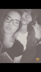
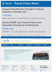
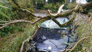
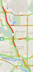
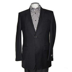
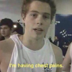

In [26]:
# HELPER FOR VARIANTS & ABLATION (MVSA-Multiple)
def _forward_feats(model, pv, ids, m):
    """
    Extract vision and text features exactly as in CLARAModel.forward.

    Returns:
      - v_feat: [B, Dv]  vision feature
      - t_feat: [B, Dt]  text feature
    """
    # Vision branch
    v_out = model.vision(pixel_values=pv)              # CLIP
    v_feat = v_out.last_hidden_state.mean(dim=1)       # global average pooling

    # Text branch
    t_out = model.text(input_ids=ids, attention_mask=m)
    t_seq = t_out.last_hidden_state                    # [B, L, H]
    mask  = m.unsqueeze(-1).float()                    # [B, L, 1]
    t_feat = (t_seq * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)

    return v_feat, t_feat


def _pred_head_logits(model, fused):
    """
    Take fused features and pass them through the prediction head.
    """
    return model.pred(fused)


def _final_logits_with_feedback(model, fused):
    """
    Reproduce the feedback logic in CLARAModel.forward:
      - Prediction head (lg_p)
      - Verification head (lg_v)
      - Feedback (p_v - p_p) → feed → final logits
    """
    lg_p = model.pred(fused)
    lg_v = model.veri(fused)

    p_v = F.softmax(lg_v / model.tau, dim=-1).detach()
    p_p = F.softmax(lg_p / model.tau, dim=-1).detach()

    ref = model.feed(torch.cat([fused, (p_v - p_p)], dim=-1))
    lg_f = model.final(ref)
    return lg_f


@torch.no_grad()
def evaluate_variant(model, loader, device, variant="full"):
    """
    Evaluate a specific variant on the TEST set.

    variant ∈ {
        "full",
        "w/o_verification",
        "w/o_feedback",
        "w/o_coattn",
        "text_only",
        "vision_only"
    }

    Uses y_true_np (derived from te_Y in FINAL EVAL) to compute
    Accuracy and F1-Weighted.
    """
    if variant == "full":
        P = _predict_full(model, loader, device)
    elif variant == "w/o_verification":
        P = _predict_wo_verification(model, loader, device)
    elif variant == "w/o_feedback":
        P = _predict_wo_feedback(model, loader, device)
    elif variant == "w/o_coattn":
        P = _predict_wo_coattn(model, loader, device)
    elif variant == "text_only":
        P = _predict_text_only(model, loader, device)
    elif variant == "vision_only":
        P = _predict_vision_only(model, loader, device)
    else:
        raise ValueError(f"Unknown variant: {variant}")

    # y_true_np is defined earlier as:
    # y_true_np = np.array(te_Y, dtype=np.int64)
    y_true = y_true_np

    acc = accuracy_score(y_true, P)
    f1w = f1_score(y_true, P, average="weighted")
    return acc, f1w

# ============================== CASE ANALYSIS ==============================

from IPython.display import HTML, display
import html, io, base64

id2name      = {0: "positive", 1: "neutral", 2: "negative"}
id2name_cap  = {0: "Positive", 1: "Neutral", 2: "Negative"}
id2abbr      = {0: "P", 1: "NT", 2: "NG"}


def _mark(pred_id, true_id):
    return f"{id2abbr[int(pred_id)]} " + ("(✓)" if int(pred_id) == int(true_id) else "(×)")


def _short_text(s, n=90):
    s = (s or "").replace("\n", " ").strip()
    return (s[:n] + "…") if len(s) > n else s


def _thumb_b64(path, size=(92, 72)):
    try:
        im = Image.open(path).convert("RGB")
        im.thumbnail(size)
    except Exception:
        im = Image.new("RGB", size, (220, 220, 220))
    buf = io.BytesIO()
    im.save(buf, format="PNG")
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("utf-8")


@torch.no_grad()
def _predict_full(model, loader, device):
    """Full CLARA: Co-Attn + Verification + Feedback."""
    model.eval()
    P = []
    for b in loader:
        pv  = b["pixel_values"].to(device, non_blocking=True)
        ids = b["input_ids"].to(device, non_blocking=True)
        m   = b["attention_mask"].to(device, non_blocking=True)
        v_feat, t_feat = _forward_feats(model, pv, ids, m)
        fused = model.fusion(v_feat, t_feat)
        lg    = _final_logits_with_feedback(model, fused)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)


@torch.no_grad()
def _predict_wo_verification(model, loader, device):
    """Without verification: use prediction head directly, still with Co-Attn."""
    model.eval()
    P = []
    for b in loader:
        pv  = b["pixel_values"].to(device, non_blocking=True)
        ids = b["input_ids"].to(device, non_blocking=True)
        m   = b["attention_mask"].to(device, non_blocking=True)
        v_feat, t_feat = _forward_feats(model, pv, ids, m)
        fused = model.fusion(v_feat, t_feat)
        lg    = _pred_head_logits(model, fused)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)


@torch.no_grad()
def _predict_wo_feedback(model, loader, device):
    """
    Without the feedback loop: in the current architecture this is equivalent
    to using the prediction head directly (same as w/o_verification in terms of logits).
    """
    return _predict_wo_verification(model, loader, device)


@torch.no_grad()
def _predict_wo_coattn(model, loader, device):
    """Without Co-Attn: simply average the two projected vision/text features."""
    model.eval()
    P = []
    for b in loader:
        pv  = b["pixel_values"].to(device, non_blocking=True)
        ids = b["input_ids"].to(device, non_blocking=True)
        m   = b["attention_mask"].to(device, non_blocking=True)
        v_feat, t_feat = _forward_feats(model, pv, ids, m)
        v_h = model.fusion.v_proj(v_feat)
        t_h = model.fusion.t_proj(t_feat)
        fused = F.layer_norm(0.5 * (v_h + t_h), (v_h.shape[-1],))
        lg    = _pred_head_logits(model, fused)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)


@torch.no_grad()
def _predict_text_only(model, loader, device):
    """Text-only branch → project text → prediction head."""
    model.eval()
    P = []
    for b in loader:
        ids = b["input_ids"].to(device, non_blocking=True)
        m   = b["attention_mask"].to(device, non_blocking=True)
        t_out = model.text(input_ids=ids, attention_mask=m)
        t_seq = t_out.last_hidden_state
        mask  = m.unsqueeze(-1).float()
        t_feat = (t_seq * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)
        h = model.fusion.t_proj(t_feat)
        lg = _pred_head_logits(model, h)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)


@torch.no_grad()
def _predict_vision_only(model, loader, device):
    """Vision-only branch → project vision → prediction head."""
    model.eval()
    P = []
    for b in loader:
        pv = b["pixel_values"].to(device, non_blocking=True)
        v_out = model.vision(pixel_values=pv)
        v_feat = v_out.last_hidden_state.mean(dim=1)
        h = model.fusion.v_proj(v_feat)
        lg = _pred_head_logits(model, h)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)


# y_true taken from evaluate() earlier on TEST
y_true_np = np.array(te_Y, dtype=np.int64)

# Get prediction of each variant
pred_wo_ver = _predict_wo_verification(model, test_loader, device)
pred_wo_fb  = _predict_wo_feedback(model,     test_loader, device)
pred_wo_ca  = _predict_wo_coattn(model,      test_loader, device)
pred_text   = _predict_text_only(model,      test_loader, device)
pred_vision = _predict_vision_only(model,    test_loader, device)
pred_ours   = _predict_full(model,           test_loader, device)


def _pick_indices_weighted_random(y_true, pred_ours, others_preds, k=6, alpha=2.0):
    """
    Pick cases where:
      - CLARA (Ours) predicts correctly; and
      - The more other variants get them wrong, the higher their selection weight.

    Larger alpha → more emphasis on cases where other variants fail.
    """
    idx_correct = np.where(pred_ours == y_true)[0]
    if len(idx_correct) == 0:
        return []
    others = np.stack(others_preds, axis=0)   # [num_variants, N]
    y = y_true[None, :]                       # [1, N]
    wrong_mat = (others != y)                 # [num_variants, N]
    wrong_count = wrong_mat[:, idx_correct].sum(axis=0).astype(float)  # [num_correct]

    eps = 1e-6
    weights = (wrong_count + eps) ** alpha
    weights = weights / weights.sum()

    size = min(k, len(idx_correct))
    chosen = np.random.choice(idx_correct, size=size, replace=False, p=weights)
    return chosen.tolist()


others_list = [pred_wo_ver, pred_wo_fb, pred_wo_ca, pred_text, pred_vision]
sample_indices = _pick_indices_weighted_random(
    y_true_np, pred_ours, others_list, k=6, alpha=2.0
)


def render_case_table(indices, title="Case analysis of CLARA variants (MVSA-Multiple)"):
    if len(indices) == 0:
        print("No suitable samples found. Try increasing k or relaxing the conditions.")
        return

    head_cols = [
        "Sample", "Text", "Image", "True",
        "w/o Verification", "w/o Feedback", "w/o Co-Attention",
        "Text-only", "Image-only", "CLARA (Ours)"
    ]
    thead = "".join([
        f'<th style="padding:8px; border:1px solid #eee; text-align:center;">{c}</th>'
        for c in head_cols
    ])

    rows_html = []
    for idx_k, i in enumerate(indices):
        s = test_samples[i]
        text_short = html.escape(_short_text(s.text, 90))

        if s.image_path and os.path.exists(s.image_path):
            img_b64 = _thumb_b64(s.image_path)
            img_tag = f'<img src="{img_b64}" style="border-radius:6px;border:1px solid #ddd;">'
        else:
            img_tag = (
                '<div style="width:92px;height:72px;'
                'border:1px dashed #ccc;border-radius:6px;'
                'background:#fafafa;"></div>'
            )

        true_name = id2name_cap[int(y_true_np[i])]

        rows_html.append(f"""
        <tr>
          <td style="text-align:center;">({chr(ord('a')+idx_k)})</td>
          <td style="vertical-align:middle; width:30%;">{text_short}</td>
          <td style="text-align:center;">{img_tag}</td>
          <td style="text-align:center;">{true_name}</td>
          <td style="text-align:center;">{_mark(pred_wo_ver[i],  y_true_np[i])}</td>
          <td style="text-align:center;">{_mark(pred_wo_fb[i],   y_true_np[i])}</td>
          <td style="text-align:center;">{_mark(pred_wo_ca[i],   y_true_np[i])}</td>
          <td style="text-align:center;">{_mark(pred_text[i],    y_true_np[i])}</td>
          <td style="text-align:center;">{_mark(pred_vision[i],  y_true_np[i])}</td>
          <td style="text-align:center; font-weight:600;">{_mark(pred_ours[i],   y_true_np[i])}</td>
        </tr>
        """)

    # Dataset-wide metrics (Acc + F1-Weighted, not Macro-F1)
    metrics_lines = []
    for name, P in {
        "w/o Verification": pred_wo_ver,
        "w/o Feedback":     pred_wo_fb,
        "w/o Co-Attention": pred_wo_ca,
        "Text-only":        pred_text,
        "Image-only":       pred_vision,
        "CLARA (Ours)":     pred_ours
    }.items():
        acc = accuracy_score(y_true_np, P)
        f1w = f1_score(y_true_np, P, average="weighted")
        metrics_lines.append(f"{name}: Acc={acc:.4f} | F1-Weighted={f1w:.4f}")

    metrics_html = "<br>".join(metrics_lines)

    html_table = f"""
    <div style="margin:8px 0;">
      <h4 style="margin:6px 0;">{html.escape(title)}</h4>
      <table style="width:100%; border-collapse:collapse; font-family:Arial, sans-serif; font-size:14px;">
        <thead><tr style="background:#f7f7f7;">{thead}</tr></thead>
        <tbody>{''.join(rows_html)}</tbody>
      </table>
      <div style="font-size:12px; color:#666; margin-top:6px;">
        *P = Positive, NT = Neutral, NG = Negative
      </div>
      <div style="font-size:13px; color:#444; margin-top:10px;">
        <b>Dataset-wide metrics</b><br>{metrics_html}
      </div>
    </div>
    """
    display(HTML(html_table))


render_case_table(sample_indices)


In [20]:
# Run ABLATION on TEST set
abl_rows = []
for name, key in [
    ("Full",             "full"),
    ("w/o Verification", "w/o_verification"),
    ("w/o Feedback",     "w/o_feedback"),
    ("w/o Co-Attention", "w/o_coattn"),
    ("Text-only",        "text_only"),
    ("Vision-only",      "vision_only"),
]:
    acc, f1w = evaluate_variant(model, test_loader, device, variant=key)
    abl_rows.append({"Variant": name, "Acc": acc, "F1-Weighted": f1w})

abl_df = pd.DataFrame(abl_rows)
best_idx_abl = abl_df['F1-Weighted'].idxmax()

print("\n" + "="*66)
print("ABLATION STUDY (evaluation-only, TEST set)")
print("="*66)

# Board with pandas Styler
def _style_abl(df, best_idx):

    sty = (
        df.copy()
        .style
        .hide(axis="index")
        .format({"Acc": "{:.4f}", "F1-Weighted": "{:.4f}"})
        .set_properties(**{
            "text-align": "center",
            "padding": "6px",
            "border": "1px solid #eee",
        })
        .set_table_styles([
            {"selector": "th", "props": [("text-align", "center"),
                                         ("padding", "6px"),
                                         ("border", "1px solid #eee"),
                                         ("background-color", "#f7f7f7")]},
            {"selector": "tbody tr:nth-child(even)",
             "props": [("background-color", "#fafafa")]},
        ])
        .background_gradient(subset=["F1-Weighted"], cmap="Blues")
    )
    # highlight hàng tốt nhất
    def _highlight_best(row):
        color = "#e99935" if row.name == best_idx else ""
        return ["background-color: {}".format(color) if col == "F1-Weighted" else ""
                for col in row.index]
    sty = sty.apply(_highlight_best, axis=1)
    return sty

display(_style_abl(abl_df, best_idx_abl))

print("\n🏆 Best variant by F1-Weighted:")
print(
    abl_df.loc[[best_idx_abl]].to_string(
        index=False,
        formatters={
            "Acc": lambda x: f"{x:.4f}",
            "F1-Weighted": lambda x: f"{x:.4f}",
        },
    )
)



ABLATION STUDY (evaluation-only, TEST set)


Variant,Acc,F1-Weighted
Full,0.7351,0.7345
w/o Verification,0.7351,0.7342
w/o Feedback,0.7351,0.7342
w/o Co-Attention,0.6175,0.4810
Text-only,0.6660,0.6271
Vision-only,0.6101,0.4623



🏆 Best variant by F1-Weighted:
Variant    Acc F1-Weighted
   Full 0.7351      0.7345
